# About the notebook
This script contains the results ofthree different ensemble methods (leave-one-out cross-validation, 10-fold cross-validation and bootstrapping) to get more robust predictions in my high dimensional dataset. 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.signal import savgol_filter

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve,auc,accuracy_score,precision_recall_curve
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut

# Read in the data

In [3]:
# params
cancer_type = "breast_cancer"
GC = "corrected"
score = "MIDPOINT"
amplitude = "FFT"

In [4]:
# cancer features
file = "/data/gpfs-1/groups/ag_kircher/cfDNA-analysis/lea/cfDNA_classification_analyses/features/DELFI_"+cancer_type+"_"+GC+"_"+score+"_"+amplitude+"_features.csv"
c_features = pd.read_csv(file, sep="\t", index_col=0)

file = "/data/gpfs-1/groups/ag_kircher/cfDNA-analysis/lea/cfDNA_classification_analyses/features/DELFI_breast_cancer_metadata.tsv"
c_meta = pd.read_csv(file, sep='\t', index_col='sample_name')

c_features = c_features.reset_index(drop=False)
c_features[['sample','p','score']] = c_features['index'].str.split('_',2, expand=True)
c_features = c_features.set_index('sample')
cancer = pd.concat([c_features, c_meta], axis=1)

In [5]:
# healthy features
file = "/data/gpfs-1/groups/ag_kircher/cfDNA-analysis/lea/cfDNA_classification_analyses/features/DELFI_healthy_"+GC+"_"+score+"_"+amplitude+"_features.csv"
h_features = pd.read_csv(file, sep="\t", index_col=0)

file = "/data/gpfs-1/groups/ag_kircher/cfDNA-analysis/lea/cfDNA_classification_analyses/features/DELFI_healthy_metadata.tsv"
h_meta = pd.read_csv(file, sep='\t', index_col='sample_name')

h_features = h_features.reset_index(drop=False)
h_features[['sample','p','score']] = h_features['index'].str.split('_',2, expand=True)
h_features = h_features.set_index('sample')
healthy = pd.concat([h_features, h_meta], axis=1)

In [6]:
# concat breast cancer and healthy
data = pd.concat([cancer, healthy], axis=0) #pd.concat([data1, data2], axis=0)
features = data.columns[(data.columns.str.startswith('central_cov')) | (data.columns.str.startswith('mean_cov')) | (data.columns.str.startswith('amplitude')) | (data.columns.str.startswith('nucleosome_spacing'))]
data.head()

,index,phenotype,central_coverage_NFKB2,mean_coverage_NFKB2,amplitude190_NFKB2,nucleosome_spacing_fft_NFKB2,central_coverage_TP73,mean_coverage_TP73,amplitude190_TP73,nucleosome_spacing_fft_TP73,...,Gender,Stage,Age,Status,% GC,Length,Median,≥ 1X,≥ 5X,fraction
EGAF00002727253,EGAF00002727253_c_MIDPOINT,1.0,0.921859,0.999899,5.964870,148.0,0.993629,0.999585,15.140059,192.0,...,F,I,54.0,breast_cancer,41%,140 bp,2.0X,88.0%,1.0%,0.06429
EGAF00002727240,EGAF00002727240_c_MIDPOINT,1.0,0.966934,1.000200,19.353707,192.0,1.033113,1.000039,9.433198,240.0,...,F,II,61.0,breast_cancer,42%,143 bp,2.0X,88.0%,3.0%,0.36440
EGAF00002727280,EGAF00002727280_c_MIDPOINT,1.0,1.161236,0.999987,11.505221,213.0,1.115174,0.999805,17.278634,192.0,...,F,II,37.0,breast_cancer,42%,134 bp,2.0X,86.0%,1.0%,0.09767
EGAF00002727290,EGAF00002727290_c_MIDPOINT,1.0,1.027811,0.999776,20.178665,192.0,1.038958,1.000246,3.898227,160.0,...,F,II,48.0,breast_cancer,41%,139 bp,2.0X,89.0%,2.0%,0.06922
EGAF00002727254,EGAF00002727254_c_MIDPOINT,1.0,1.118326,1.000246,10.611337,213.0,1.166457,0.999947,1.834101,213.0,...,F,II,47.0,breast_cancer,41%,134 bp,1.0X,86.0%,1.0%,0.11470


In [7]:
#scale data
scaled_data = pd.concat([cancer, healthy], axis=0) 
scaler = StandardScaler()
scaler.fit(scaled_data[features])
scaled_data[features] = scaler.transform(scaled_data[features])

scaled_data.head()

,index,phenotype,central_coverage_NFKB2,mean_coverage_NFKB2,amplitude190_NFKB2,nucleosome_spacing_fft_NFKB2,central_coverage_TP73,mean_coverage_TP73,amplitude190_TP73,nucleosome_spacing_fft_TP73,...,Gender,Stage,Age,Status,% GC,Length,Median,≥ 1X,≥ 5X,fraction
EGAF00002727253,EGAF00002727253_c_MIDPOINT,1.0,-1.587964,-0.402804,-1.431977,-2.181180,-1.235524,-2.211313,0.879156,-0.406840,...,F,I,54.0,breast_cancer,41%,140 bp,2.0X,88.0%,1.0%,0.06429
EGAF00002727240,EGAF00002727240_c_MIDPOINT,1.0,-0.575681,1.081786,0.380465,-0.469377,-0.233665,0.148223,-0.184884,1.386579,...,F,II,61.0,breast_cancer,42%,143 bp,2.0X,88.0%,3.0%,0.36440
EGAF00002727280,EGAF00002727280_c_MIDPOINT,1.0,3.787805,0.031149,-0.681981,0.347620,1.848499,-1.066968,1.277891,-0.406840,...,F,II,37.0,breast_cancer,42%,134 bp,2.0X,86.0%,1.0%,0.09767
EGAF00002727290,EGAF00002727290_c_MIDPOINT,1.0,0.791448,-1.014266,0.492140,-0.469377,-0.085350,1.227604,-1.216876,-1.602453,...,F,II,48.0,breast_cancer,41%,139 bp,2.0X,89.0%,2.0%,0.06922
EGAF00002727254,EGAF00002727254_c_MIDPOINT,1.0,2.824170,1.308605,-0.802986,0.347620,3.149750,-0.327229,-1.601730,0.377780,...,F,II,47.0,breast_cancer,41%,134 bp,1.0X,86.0%,1.0%,0.11470


# Functions

In [8]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), stats.sem(a) #standard error of the mean
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [9]:
def plot_roc_curve(tpr,fpr,AUC):
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'k', label = 'AUC = %0.2f' % AUC)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'b--')
    #plt.xlim([0, 1])
    #plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

## Leave-one-out cross-validation functions

In [10]:
def LR_loo(data,pca_flag,default_flag,all_features):

    X = data[all_features]
    y = data.loc[:,"phenotype"]

    loo = LeaveOneOut()
    y_true, y_pred, y_prob = list(), list(), list()
    
    all_performance = pd.DataFrame()
    feature_importances = pd.DataFrame(index=all_features)

    for i, (train_index, test_index) in enumerate(loo.split(X)):

        X_train = X.iloc[train_index, :]
        X_test = X.iloc[test_index, :]
        y_train = y[train_index]
        y_test = y[test_index]
        
        fraction_variance = .8
        if pca_flag:
        #perform PCA on the training set
            n_components = min(len(all_features), len(X_train))
            pca = PCA(n_components=n_components, svd_solver='randomized', random_state = 100)
            PCs = pca.fit_transform(X_train[all_features])
            principal_components = pd.DataFrame(data = PCs, columns = ['PC_'+str(m) for m in np.arange(n_components)], index = X_train.index)

            #find the principle components that make up 80% of the varience
            for j in range(len(pca.explained_variance_ratio_)):
                current_sum = pca.explained_variance_ratio_[:j].sum()
                if current_sum>=fraction_variance:
                    break
            pca_features = ['PC_'+str(m) for m in np.arange(0,j)]

            #apply to the test data
            test_PCs = pca.transform(X_test[all_features])
            test_principal_components = pd.DataFrame(data = test_PCs , columns = ['PC_'+str(m) for m in np.arange(n_components)], index = X_test.index)

            X_train = principal_components[pca_features]
            X_test = test_principal_components[pca_features]
        
        if default_flag:
            model = LogisticRegression()
        else:
            model = LogisticRegression(C=0.1, class_weight=None, max_iter=500, penalty='l1', solver='liblinear')
        model.fit(X_train, y_train)

        pred = model.predict(X_test)
        prob = model.predict_proba(X_test)
        feature_importances['imp_'+str(i)] = pd.DataFrame(data=model.coef_[0], index=all_features)

        y_true.append(y_test[0])
        y_pred.append(pred[0])
        y_prob.append(prob[:,1])

    acc = accuracy_score(y_true, y_pred)
    fpr,tpr,_ = roc_curve(y_true, y_prob)
    AUC = auc(fpr,tpr)
    
    current_dict = {}
    current_dict['fpr'] = fpr
    current_dict['tpr'] = tpr
    current_dict['accuracy'] = acc
    current_dict['auc'] = AUC
    all_performance = pd.Series(current_dict)

    return(all_performance,feature_importances)

In [11]:
def RF_loo(data,pca_flag,default_flag,all_features):

    X = data[features]
    y = data.loc[:,"phenotype"]

    loo = LeaveOneOut()
    y_true, y_pred, y_prob = list(), list(), list()
    
    all_performance = pd.DataFrame()
    feature_importances = pd.DataFrame(index=all_features)

    for i, (train_index, test_index) in enumerate(loo.split(X)):

        X_train = X.iloc[train_index, :]
        X_test = X.iloc[test_index, :]
        y_train = y[train_index]
        y_test = y[test_index]
        
        fraction_variance = .8
        if pca_flag:
        #perform PCA on the training set
            n_components = min(len(all_features), len(X_train))
            pca = PCA(n_components=n_components, svd_solver='randomized', random_state = 100)
            PCs = pca.fit_transform(X_train[all_features])
            principal_components = pd.DataFrame(data = PCs, columns = ['PC_'+str(m) for m in np.arange(n_components)], index = X_train.index)

            #find the principle components that make up 80% of the varience
            for j in range(len(pca.explained_variance_ratio_)):
                current_sum = pca.explained_variance_ratio_[:j].sum()
                if current_sum>=fraction_variance:
                    break
            pca_features = ['PC_'+str(m) for m in np.arange(0,j)]

            #apply to the test data
            test_PCs = pca.transform(X_test[all_features])
            test_principal_components = pd.DataFrame(data = test_PCs , columns = ['PC_'+str(m) for m in np.arange(n_components)], index = X_test.index)

            X_train = principal_components[pca_features]
            X_test = test_principal_components[pca_features]
        
        if default_flag:
            model = RandomForestClassifier()
        else:
            model = RandomForestClassifier(n_estimators=500, min_samples_split=3, min_samples_leaf=2, 
                                       max_features='sqrt', max_depth=8, criterion='gini', bootstrap=True)
        model.fit(X_train, y_train)

        pred = model.predict(X_test)
        prob = model.predict_proba(X_test)
        feature_importances['imp_'+str(i)] = pd.DataFrame(data=model.feature_importances_, index=all_features)

        y_true.append(y_test[0])
        y_pred.append(pred[0])
        y_prob.append(prob[:,1])

    acc = accuracy_score(y_true, y_pred)
    fpr,tpr,_ = roc_curve(y_true, y_prob)
    AUC = auc(fpr,tpr)
    
    current_dict = {}
    current_dict['fpr'] = fpr
    current_dict['tpr'] = tpr
    current_dict['accuracy'] = acc
    current_dict['auc'] = AUC
    all_performance = pd.Series(current_dict)
    
    return(all_performance,feature_importances)

In [12]:
def GBC_loo(data,pca_flag,default_flag,all_features):

    X = data[features]
    y = data.loc[:,"phenotype"]

    loo = LeaveOneOut()
    y_true, y_pred, y_prob = list(), list(), list()
    
    all_performance = pd.DataFrame()
    feature_importances = pd.DataFrame(index=all_features)

    for i, (train_index, test_index) in enumerate(loo.split(X)):

        X_train = X.iloc[train_index, :]
        X_test = X.iloc[test_index, :]
        y_train = y[train_index]
        y_test = y[test_index]
        
        fraction_variance = .8
        if pca_flag:
        #perform PCA on the training set
            n_components = min(len(all_features), len(X_train))
            pca = PCA(n_components=n_components, svd_solver='randomized', random_state = 100)
            PCs = pca.fit_transform(X_train[all_features])
            principal_components = pd.DataFrame(data = PCs, columns = ['PC_'+str(m) for m in np.arange(n_components)], index = X_train.index)

            #find the principle components that make up 80% of the varience
            for j in range(len(pca.explained_variance_ratio_)):
                current_sum = pca.explained_variance_ratio_[:j].sum()
                if current_sum>=fraction_variance:
                    break
            #print('total components',len(pca.explained_variance_ratio_),'number of components:',j)
            pca_features = ['PC_'+str(m) for m in np.arange(0,j)]

            #apply to the test data
            test_PCs = pca.transform(X_test[all_features])
            test_principal_components = pd.DataFrame(data = test_PCs , columns = ['PC_'+str(m) for m in np.arange(n_components)], index = X_test.index)

            X_train = principal_components[pca_features]
            X_test = test_principal_components[pca_features]
        
        if default_flag:
            model = GradientBoostingClassifier()
        else:
            model = GradientBoostingClassifier(n_estimators=500, min_samples_split=3, min_samples_leaf=2, 
                                           max_features='sqrt', max_depth=3, criterion='friedman_mse', 
                                           subsample=1, learning_rate=0.1)
        model.fit(X_train, y_train)

        pred = model.predict(X_test)
        prob = model.predict_proba(X_test)
        feature_importances['imp_'+str(i)] = pd.DataFrame(data=model.feature_importances_, index=all_features)

        y_true.append(y_test[0])
        y_pred.append(pred[0])
        y_prob.append(prob[:,1])

    acc = accuracy_score(y_true, y_pred)
    fpr,tpr,_ = roc_curve(y_true, y_prob)
    AUC = auc(fpr,tpr)
    
    current_dict = {}
    current_dict['fpr'] = fpr
    current_dict['tpr'] = tpr
    current_dict['accuracy'] = acc
    current_dict['auc'] = AUC
    all_performance = pd.Series(current_dict)
    
    return(all_performance,feature_importances)

## Bootstrapping functions

In [13]:
def RF_bootstrap(input_data,pca_flag,iterations,default_flag,all_features):

    all_performance = pd.DataFrame()
    feature_importances = pd.DataFrame(index=all_features)
    
    for i in range(iterations):
        train = input_data.sample(len(input_data), replace = True)
        test = input_data[~(input_data.index.isin(train.index))]

        X_train = train[all_features]
        y_train = train.loc[:,"phenotype"]
        X_test = test[all_features]
        y_test = test.loc[:,"phenotype"]

        fraction_variance = .8
        if pca_flag:
        #perform PCA on the training set
            n_components = min(len(all_features), len(X_train))
            pca = PCA(n_components=n_components, svd_solver='randomized', random_state = 100)
            PCs = pca.fit_transform(X_train[all_features])
            principal_components = pd.DataFrame(data = PCs, columns = ['PC_'+str(m) for m in np.arange(n_components)], index = X_train.index)

            #find the principle components that make up 80% of the varience
            for j in range(len(pca.explained_variance_ratio_)):
                current_sum = pca.explained_variance_ratio_[:j].sum()
                if current_sum>=fraction_variance:
                    break
            #print('total components',len(pca.explained_variance_ratio_),'number of components:',j)
            pca_features = ['PC_'+str(m) for m in np.arange(0,j)]

            #apply to the test data
            test_PCs = pca.transform(X_test[all_features])
            test_principal_components = pd.DataFrame(data = test_PCs , columns = ['PC_'+str(m) for m in np.arange(n_components)], index = X_test.index)

            X_train = principal_components[pca_features]
            X_test = test_principal_components[pca_features]
        
        if default_flag:
            model = RandomForestClassifier()
        else:
            model = RandomForestClassifier(n_estimators=500, min_samples_split=3, min_samples_leaf=2, 
                                       max_features='sqrt', max_depth=8, criterion='gini', bootstrap=True)
        model.fit(X_train, y_train)

        pred = model.predict(X_test)
        prob = model.predict_proba(X_test)
        
        feature_importances['imp_'+str(i)] = pd.DataFrame(data=model.feature_importances_, index=all_features)
        
        current_dict = {}
        acc = accuracy_score(y_test, pred)
        fpr,tpr,_ = roc_curve(y_test, prob[:,1])
        AUC = auc(fpr,tpr)
        current_dict['fpr'] = fpr
        current_dict['tpr'] = tpr
        current_dict['accuracy'] = acc
        current_dict['auc'] = AUC
        all_performance = all_performance.append(pd.Series(current_dict), ignore_index=True)

    return(all_performance,feature_importances)

In [14]:
def LR_bootstrap(input_data,pca_flag,iterations,default_flag,all_features):
    
    all_performance = pd.DataFrame()
    feature_importances = pd.DataFrame(index=all_features)
    
    for i in range(iterations):
        train = input_data.sample(len(input_data), replace = True)
        test = input_data[~(input_data.index.isin(train.index))]

        X_train = train[all_features]
        y_train = train.loc[:,"phenotype"]
        X_test = test[all_features]
        y_test = test.loc[:,"phenotype"]

        fraction_variance = .8
        if pca_flag:
        #perform PCA on the training set
            n_components = min(len(all_features), len(X_train))
            pca = PCA(n_components=n_components, svd_solver='randomized', random_state = 100)
            PCs = pca.fit_transform(X_train[all_features])
            principal_components = pd.DataFrame(data = PCs, columns = ['PC_'+str(m) for m in np.arange(n_components)], index = X_train.index)

            #find the principle components that make up 80% of the varience
            for j in range(len(pca.explained_variance_ratio_)):
                current_sum = pca.explained_variance_ratio_[:j].sum()
                if current_sum>=fraction_variance:
                    break
            #print('total components',len(pca.explained_variance_ratio_),'number of components:',j)
            pca_features = ['PC_'+str(m) for m in np.arange(0,j)]

            #apply to the test data
            test_PCs = pca.transform(X_test[all_features])
            test_principal_components = pd.DataFrame(data = test_PCs , columns = ['PC_'+str(m) for m in np.arange(n_components)], index = X_test.index)

            X_train = principal_components[pca_features]
            X_test = test_principal_components[pca_features]
        
        if default_flag:
            model = LogisticRegression()
        else:
            model = LogisticRegression(C=0.1, class_weight=None, max_iter=500, penalty='l1', solver='liblinear')
        model.fit(X_train, y_train)

        pred = model.predict(X_test)
        prob = model.predict_proba(X_test)
        
        feature_importances['imp_'+str(i)] = pd.DataFrame(data=model.coef_[0], index=all_features)
        
        current_dict = {}
        acc = accuracy_score(y_test, pred)
        fpr,tpr,_ = roc_curve(y_test, prob[:,1])
        AUC = auc(fpr,tpr)
        current_dict['fpr'] = fpr
        current_dict['tpr'] = tpr
        current_dict['accuracy'] = acc
        current_dict['auc'] = AUC
        all_performance = all_performance.append(pd.Series(current_dict), ignore_index=True)
    return(all_performance,feature_importances)

In [15]:
def GBC_bootstrap(input_data,pca_flag,iterations,default_flag,all_features):

    all_performance = pd.DataFrame()
    for i in range(iterations):
        train = input_data.sample(len(input_data), replace = True)
        test = input_data[~(input_data.index.isin(train.index))]

        X_train = train[all_features]
        y_train = train.loc[:,"phenotype"]
        X_test = test[all_features]
        y_test = test.loc[:,"phenotype"]

        fraction_variance = .8
        
        if pca_flag:
        #perform PCA on the training set
            n_components = min(len(all_features), len(X_train))
            pca = PCA(n_components=n_components, svd_solver='randomized', random_state = 100)
            PCs = pca.fit_transform(X_train[all_features])
            principal_components = pd.DataFrame(data = PCs, columns = ['PC_'+str(m) for m in np.arange(n_components)], index = X_train.index)

            #find the principle components that make up 80% of the varience
            for j in range(len(pca.explained_variance_ratio_)):
                current_sum = pca.explained_variance_ratio_[:j].sum()
                if current_sum>=fraction_variance:
                    break
            #print('total components',len(pca.explained_variance_ratio_),'number of components:',j)
            pca_features = ['PC_'+str(m) for m in np.arange(0,j)]

            #apply to the test data
            test_PCs = pca.transform(X_test[all_features])
            test_principal_components = pd.DataFrame(data = test_PCs , columns = ['PC_'+str(m) for m in np.arange(n_components)], index = X_test.index)

            X_train = principal_components[pca_features]
            X_test = test_principal_components[pca_features]

        if default_flag:
            model = GradientBoostingClassifier()
        else:
            model = GradientBoostingClassifier(n_estimators=500, min_samples_split=3, min_samples_leaf=2, 
                                           max_features='sqrt', max_depth=3, criterion='friedman_mse', 
                                           subsample=1, learning_rate=0.1)
        model.fit(X_train, y_train)

        pred = model.predict(X_test)
        prob = model.predict_proba(X_test)
        
        current_dict = {}
        acc = accuracy_score(y_test, pred)
        fpr,tpr,_ = roc_curve(y_test, prob[:,1])
        AUC = auc(fpr,tpr)
        current_dict['fpr'] = fpr
        current_dict['tpr'] = tpr
        current_dict['accuracy'] = acc
        current_dict['auc'] = AUC
        all_performance = all_performance.append(pd.Series(current_dict), ignore_index=True)

    return(all_performance)

## 10-fold cross-validation functions

In [16]:
def RF_kfold_cv(data,pca_flag,folds,default_flag):

    kf = KFold(n_splits=folds, random_state=42, shuffle=True)
    all_performance = pd.DataFrame()
    
    for i, (train_index, test_index) in enumerate(kf.split(data)):
        train = data.iloc[train_index]
        test = data.iloc[test_index]

        X_train = train[features]
        y_train = train.loc[:,"phenotype"]
        X_test = test[features]
        y_test = test.loc[:,"phenotype"]
        
        fraction_variance = .8
        if pca_flag:
        #perform PCA on the training set
            n_components = min(len(features), len(X_train))
            pca = PCA(n_components=n_components, svd_solver='randomized', random_state = 100)
            PCs = pca.fit_transform(X_train[features])
            principal_components = pd.DataFrame(data = PCs, columns = ['PC_'+str(m) for m in np.arange(n_components)], index = X_train.index)

            #find the principle components that make up 80% of the varience
            for j in range(len(pca.explained_variance_ratio_)):
                current_sum = pca.explained_variance_ratio_[:j].sum()
                if current_sum>=fraction_variance:
                    break
            #print('total components',len(pca.explained_variance_ratio_),'number of components:',j)
            pca_features = ['PC_'+str(m) for m in np.arange(0,j)]

            #apply to the test data
            test_PCs = pca.transform(X_test[features])
            test_principal_components = pd.DataFrame(data = test_PCs , columns = ['PC_'+str(m) for m in np.arange(n_components)], index = X_test.index)

            X_train = principal_components[pca_features]
            X_test = test_principal_components[pca_features]
        
        if default_flag:
            model = RandomForestClassifier()
        else:
            model = RandomForestClassifier(n_estimators=500, min_samples_split=3, min_samples_leaf=2, 
                                       max_features='sqrt', max_depth=8, criterion='gini', bootstrap=True)
        model.fit(X_train, y_train)

        pred = model.predict(X_test)
        prob = model.predict_proba(X_test)
        current_dict = {}
        acc = accuracy_score(y_test, pred)
        fpr,tpr,_ = roc_curve(y_test, prob[:,1])
        AUC = auc(fpr,tpr)
        current_dict['fpr'] = fpr
        current_dict['tpr'] = tpr
        current_dict['accuracy'] = acc
        current_dict['auc'] = AUC
        all_performance = all_performance.append(pd.Series(current_dict), ignore_index=True)
    return(all_performance)

In [17]:
def LR_kfold_cv(data,pca_flag,folds,default_flag):

    kf = KFold(n_splits=folds, random_state=42, shuffle=True)
    all_performance = pd.DataFrame()
    
    for i, (train_index, test_index) in enumerate(kf.split(data)):
        train = data.iloc[train_index]
        test = data.iloc[test_index]

        X_train = train[features]
        y_train = train.loc[:,"phenotype"]
        X_test = test[features]
        y_test = test.loc[:,"phenotype"]
        
        fraction_variance = .8
        if pca_flag:
        #perform PCA on the training set
            n_components = min(len(features), len(X_train))
            pca = PCA(n_components=n_components, svd_solver='randomized', random_state = 100)
            PCs = pca.fit_transform(X_train[features])
            principal_components = pd.DataFrame(data = PCs, columns = ['PC_'+str(m) for m in np.arange(n_components)], index = X_train.index)

            #find the principle components that make up 80% of the varience
            for j in range(len(pca.explained_variance_ratio_)):
                current_sum = pca.explained_variance_ratio_[:j].sum()
                if current_sum>=fraction_variance:
                    break
            #print('total components',len(pca.explained_variance_ratio_),'number of components:',j)
            pca_features = ['PC_'+str(m) for m in np.arange(0,j)]

            #apply to the test data
            test_PCs = pca.transform(X_test[features])
            test_principal_components = pd.DataFrame(data = test_PCs , columns = ['PC_'+str(m) for m in np.arange(n_components)], index = X_test.index)

            X_train = principal_components[pca_features]
            X_test = test_principal_components[pca_features]

        if default_flag:
            model = LogisticRegression()
        else:
            model = LogisticRegression(C=0.1, class_weight=None, max_iter=500, penalty='l1', solver='liblinear')
        model.fit(X_train, y_train)

        pred = model.predict(X_test)
        prob = model.predict_proba(X_test)
        current_dict = {}
        acc = accuracy_score(y_test, pred)
        fpr,tpr,_ = roc_curve(y_test, prob[:,1])
        AUC = auc(fpr,tpr)
        current_dict['fpr'] = fpr
        current_dict['tpr'] = tpr
        current_dict['accuracy'] = acc
        current_dict['auc'] = AUC
        all_performance = all_performance.append(pd.Series(current_dict), ignore_index=True)
    return(all_performance)

In [18]:
def GBC_kfold_cv(data,pca_flag,folds,default_flag):

    kf = KFold(n_splits=folds, random_state=42, shuffle=True)
    all_performance = pd.DataFrame()
    
    for i, (train_index, test_index) in enumerate(kf.split(data)):
        train = data.iloc[train_index]
        test = data.iloc[test_index]

        X_train = train[features]
        y_train = train.loc[:,"phenotype"]
        X_test = test[features]
        y_test = test.loc[:,"phenotype"]
        
        fraction_variance = .8
        if pca_flag:
        #perform PCA on the training set
            n_components = min(len(features), len(X_train))
            pca = PCA(n_components=n_components, svd_solver='randomized', random_state = 100)
            PCs = pca.fit_transform(X_train[features])
            principal_components = pd.DataFrame(data = PCs, columns = ['PC_'+str(m) for m in np.arange(n_components)], index = X_train.index)

            #find the principle components that make up 80% of the varience
            for j in range(len(pca.explained_variance_ratio_)):
                current_sum = pca.explained_variance_ratio_[:j].sum()
                if current_sum>=fraction_variance:
                    break
            #print('total components',len(pca.explained_variance_ratio_),'number of components:',j)
            pca_features = ['PC_'+str(m) for m in np.arange(0,j)]

            #apply to the test data
            test_PCs = pca.transform(X_test[features])
            test_principal_components = pd.DataFrame(data = test_PCs , columns = ['PC_'+str(m) for m in np.arange(n_components)], index = X_test.index)

            X_train = principal_components[pca_features]
            X_test = test_principal_components[pca_features]

        if default_flag:
            model = GradientBoostingClassifier()
        else:
            model = GradientBoostingClassifier(n_estimators=500, min_samples_split=3, min_samples_leaf=2, 
                                           max_features='sqrt', max_depth=3, criterion='friedman_mse', 
                                           subsample=1, learning_rate=0.1)
        model.fit(X_train, y_train)

        pred = model.predict(X_test)
        prob = model.predict_proba(X_test)
        current_dict = {}
        acc = accuracy_score(y_test, pred)
        fpr,tpr,_ = roc_curve(y_test, prob[:,1])
        AUC = auc(fpr,tpr)
        current_dict['fpr'] = fpr
        current_dict['tpr'] = tpr
        current_dict['accuracy'] = acc
        current_dict['auc'] = AUC
        all_performance = all_performance.append(pd.Series(current_dict), ignore_index=True)
    return(all_performance)

# Leave one out

In [19]:
# Logistic Regression
lr_loo_perf,LR_LOO_final_fi = LR_loo(scaled_data,False,False,features)
lr_loo_perf

fpr         [0.0, 0.0, 0.0, 0.018518518518518517, 0.018518...
tpr         [0.0, 0.018518518518518517, 0.4629629629629629...
accuracy                                             0.787037
auc                                                   0.88546
dtype: object

In [20]:
# features with highest absolute values over all iterations
np.abs(LR_LOO_final_fi.mean(axis=1)).sort_values(ascending=False).head(10)

central_coverage_PAX5      0.631237
central_coverage_MAF       0.353900
central_coverage_CEBPB     0.291954
central_coverage_ZNF384    0.173251
amplitude190_SCRT2         0.099064
mean_coverage_ZFHX2        0.088467
amplitude190_ZNF574        0.047273
amplitude190_ZNF444        0.046076
amplitude190_KLF6          0.033876
amplitude190_MBD2          0.010633
dtype: float64

In [21]:
# features with lowest absolute values over all iterations
LR_LOO_final_fi.mean(axis=1).sort_values(ascending=False).tail(10)

amplitude190_ZFX         0.000000
central_coverage_RBPJ    0.000000
amplitude190_FOS        -0.000205
mean_coverage_GFI1B     -0.000448
mean_coverage_HIF3A     -0.000633
amplitude190_SMAD3      -0.006772
amplitude190_KLF6       -0.033876
amplitude190_ZNF444     -0.046076
amplitude190_ZNF574     -0.047273
mean_coverage_ZFHX2     -0.088467
dtype: float64

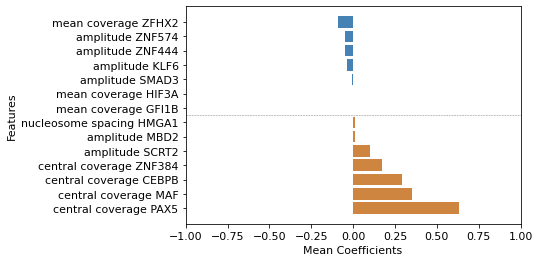

In [22]:
# Final plot for thesis

#fig = plt.gcf()
#fig.set_size_inches(9, 6)

plt.rcParams.update({'font.size': 11})
d = LR_LOO_final_fi.mean(axis=1).sort_values(ascending=False).head(7)

d = d.rename(index={'central_coverage_PAX5': 'central coverage PAX5'})
d = d.rename(index={'central_coverage_MAF': 'central coverage MAF'})
d = d.rename(index={'central_coverage_CEBPB': 'central coverage CEBPB'})
d = d.rename(index={'central_coverage_ZNF384': 'central coverage ZNF384'})
d = d.rename(index={'amplitude190_SCRT2': 'amplitude SCRT2'})
d = d.rename(index={'amplitude190_NFATC3': 'amplitude NFATC3'})
d = d.rename(index={'amplitude190_MBD2': 'amplitude MBD2'})
d = d.rename(index={'nucleosome_spacing_fft_HMGA1': 'nucleosome spacing HMGA1'})
d = d.rename(index={'nucleosome_spacing_fft_ZNF768': 'nucleosome spacing ZNF768'})
d = d.rename(index={'amplitude190_OSR2': 'amplitude OSR2'})
d = d.rename(index={'central_coverage_ZNF143': 'central coverage ZNF143'})
d = d.rename(index={'amplitude190_RBPJ': 'amplitude RBPJ'})
d = d.rename(index={'amplitude190_ARID3A': 'amplitude ARID3A'})
d = d.rename(index={'amplitude190_ZNF574': 'amplitude ZNF574'})
d = d.rename(index={'amplitude190_ZNF444': 'amplitude ZNF444'})
d = d.rename(index={'amplitude190_KLF6': 'amplitude KLF6'})
d = d.rename(index={'amplitude190_SMAD3': 'amplitude SMAD3'})
d = d.rename(index={'mean_coverage_ZFHX2': 'mean coverage ZFHX2'})
d = d.rename(index={'mean_coverage_HIF3A': 'mean coverage HIF3A'})
d = d.rename(index={'mean_coverage_GFI1B': 'mean coverage GFI1B'})

#plt.title('Logistic Regression with leave-one-out cross-validation')
plt.barh(d.index,d,color="peru")

d = LR_LOO_final_fi.mean(axis=1).sort_values(ascending=False).tail(7)
d = d.rename(index={'central_coverage_PAX5': 'central coverage PAX5'})
d = d.rename(index={'central_coverage_MAF': 'central coverage MAF'})
d = d.rename(index={'central_coverage_CEBPB': 'central coverage CEBPB'})
d = d.rename(index={'central_coverage_ZNF384': 'central coverage ZNF384'})
d = d.rename(index={'amplitude190_SCRT2': 'amplitude SCRT2'})
d = d.rename(index={'amplitude190_NFATC3': 'amplitude NFATC3'})
d = d.rename(index={'amplitude190_MBD2': 'amplitude MBD2'})
d = d.rename(index={'nucleosome_spacing_fft_HMGA1': 'nucleosome spacing HMGA1'})
d = d.rename(index={'nucleosome_spacing_fft_ZNF768': 'nucleosome spacing ZNF768'})
d = d.rename(index={'amplitude190_OSR2': 'amplitude OSR2'})
d = d.rename(index={'central_coverage_ZNF143': 'central coverage ZNF143'})
d = d.rename(index={'amplitude190_RBPJ': 'amplitude RBPJ'})
d = d.rename(index={'amplitude190_ARID3A': 'amplitude ARID3A'})
d = d.rename(index={'amplitude190_ZNF574': 'amplitude ZNF574'})
d = d.rename(index={'amplitude190_ZNF444': 'amplitude ZNF444'})
d = d.rename(index={'amplitude190_KLF6': 'amplitude KLF6'})
d = d.rename(index={'amplitude190_SMAD3': 'amplitude SMAD3'})
d = d.rename(index={'mean_coverage_ZFHX2': 'mean coverage ZFHX2'})
d = d.rename(index={'mean_coverage_HIF3A': 'mean coverage HIF3A'})
d = d.rename(index={'mean_coverage_GFI1B': 'mean coverage GFI1B'})

plt.barh(d.index,d,color="steelblue")

plt.axhline(y=6.5, color='gray', linestyle='--', linewidth=0.5)
plt.xlabel('Mean Coefficients')
plt.ylabel('Features')
plt.xlim(-1,1)

outfile = "thesis_plots/LogisticRegression_LOO.pdf"
plt.savefig(outfile,bbox_inches='tight')

In [23]:
# RF scaled data
rf_loo_perf,fi = RF_loo(scaled_data,False,False,features)
rf_loo_perf

fpr         [0.0, 0.0, 0.0, 0.037037037037037035, 0.037037...
tpr         [0.0, 0.018518518518518517, 0.5370370370370371...
accuracy                                             0.759259
auc                                                  0.861454
dtype: object

In [24]:
# GBC scaled data
gbc_loo_perf,fi = GBC_loo(data,False,False,features)
gbc_loo_perf

fpr         [0.0, 0.0, 0.0, 0.018518518518518517, 0.018518...
tpr         [0.0, 0.018518518518518517, 0.5185185185185185...
accuracy                                             0.814815
auc                                                  0.908436
dtype: object

# Bootstrapping

In [25]:
# Logistic Regression
lr_bootstrap_perf, fi = LR_bootstrap(scaled_data,False,1000,False,features)

print("Accuracy min", lr_bootstrap_perf['accuracy'].min(), "mean", lr_bootstrap_perf['accuracy'].mean(), "max", lr_bootstrap_perf['accuracy'].max())
print("AUROC min", lr_bootstrap_perf['auc'].min(), "mean", lr_bootstrap_perf['auc'].mean(), "max", lr_bootstrap_perf['auc'].max())

Accuracy min 0.5128205128205128 mean 0.7480026835862612 max 0.9166666666666666
AUROC min 0.5777310924369748 mean 0.8244481884855807 max 0.9744318181818181


In [26]:
print(lr_bootstrap_perf['accuracy'].var())
lr_bootstrap_perf['accuracy'].describe()

0.003906002485239816


count    1000.000000
mean        0.748003
std         0.062498
min         0.512821
25%         0.707317
50%         0.750000
75%         0.789474
max         0.916667
Name: accuracy, dtype: float64

In [27]:
print(lr_bootstrap_perf['auc'].var())
lr_bootstrap_perf['auc'].describe()

0.0037622336405852288


count    1000.000000
mean        0.824448
std         0.061337
min         0.577731
25%         0.783180
50%         0.830495
75%         0.867159
max         0.974432
Name: auc, dtype: float64

In [28]:
mean_confidence_interval(lr_bootstrap_perf['auc'], confidence=0.95)

(0.8244481884855807, 0.8206419371610668, 0.8282544398100945)

central coverage PAX5        0.459404
central coverage MAF         0.236714
central coverage CEBPB       0.229677
central coverage ZNF384      0.079416
amplitude SCRT2              0.050718
nucleosome spacing HMGA1     0.038631
central coverage ZNF444      0.032387
amplitude ARID3A             0.029970
amplitude NFATC3             0.028705
central coverage FLI1        0.022816
amplitude OSR2               0.022702
amplitude MBD2               0.022443
central coverage FOXK2       0.021669
amplitude WT1                0.016554
amplitude FOXK1              0.014315
amplitude190_TET3            0.014274
amplitude HES1               0.014145
nucleosome spacing ZNF768    0.013715
central coverage ZNF121      0.012122
amplitude AHR                0.012035
dtype: float64


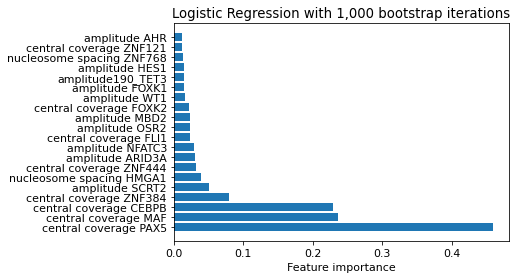

In [29]:
#fig = plt.gcf()
#fig.set_size_inches(9, 6)

d = fi.mean(axis=1).sort_values(ascending=False).head(20)
d = d.rename(index={'central_coverage_PAX5': 'central coverage PAX5'})
d = d.rename(index={'central_coverage_MAF': 'central coverage MAF'})
d = d.rename(index={'central_coverage_CEBPB': 'central coverage CEBPB'})
d = d.rename(index={'central_coverage_ZNF384': 'central coverage ZNF384'})
d = d.rename(index={'amplitude190_SCRT2': 'amplitude SCRT2'})
d = d.rename(index={'central_coverage_ZNF444': 'central coverage ZNF444'})
d = d.rename(index={'amplitude190_ARID3A': 'amplitude ARID3A'})
d = d.rename(index={'nucleosome_spacing_fft_HMGA1': 'nucleosome spacing HMGA1'})
d = d.rename(index={'amplitude190_MBD2': 'amplitude MBD2'})
d = d.rename(index={'central_coverage_FOXK2': 'central coverage FOXK2'})
d = d.rename(index={'amplitude190_NFATC3': 'amplitude NFATC3'})
d = d.rename(index={'amplitude190_OSR2': 'amplitude OSR2'})
d = d.rename(index={'central_coverage_FLI1': 'central coverage FLI1'})
d = d.rename(index={'amplitude190_FOXK1': 'amplitude FOXK1'})
d = d.rename(index={'amplitude190_WT1': 'amplitude WT1'})
d = d.rename(index={'amplitude190_RBPJ': 'amplitude RBPJ'})
d = d.rename(index={'nucleosome_spacing_fft_ZNF768': 'nucleosome spacing ZNF768'})
d = d.rename(index={'amplitude190_HES1': 'amplitude HES1'})
d = d.rename(index={'central_coverage_ZNF121': 'central coverage ZNF121'})
d = d.rename(index={'amplitude190_AHR': 'amplitude AHR'})
print(d)

outfile = "thesis_plots/LogisticRegression_bootstrap.pdf"

plt.title('Logistic Regression with 1,000 bootstrap iterations')
plt.barh(d.index,d)

plt.xlabel('Feature importance')

plt.savefig(outfile,bbox_inches='tight')

In [40]:
# Logistic Regression with PCA
#lr_bootstrap_PCA_perf,fi = LR_bootstrap(scaled_data,True,1000,False,features)

#print("Accuracy min", lr_bootstrap_PCA_perf['accuracy'].min(), "mean", lr_bootstrap_PCA_perf['accuracy'].mean(), "max", lr_bootstrap_PCA_perf['accuracy'].max())
#print("AUROC min", lr_bootstrap_PCA_perf['auc'].min(), "mean", lr_bootstrap_PCA_perf['auc'].mean(), "max", lr_bootstrap_PCA_perf['auc'].max())

#lr_bootstrap_PCA_perf['auc'].mean()

In [36]:
# Random Forest
rf_bootstrap_perf,fi = RF_bootstrap(scaled_data,False,1000,False,features)

In [37]:
print(rf_bootstrap_perf['accuracy'].var())
rf_bootstrap_perf['accuracy'].describe()

0.004685800312566773


count    1000.000000
mean        0.755731
std         0.068453
min         0.394737
25%         0.714286
50%         0.757166
75%         0.804878
max         0.972222
Name: accuracy, dtype: float64

In [38]:
print(rf_bootstrap_perf['auc'].var())
rf_bootstrap_perf['auc'].describe()

0.0029735806749315386


count    1000.000000
mean        0.864633
std         0.054531
min         0.634503
25%         0.833333
50%         0.869246
75%         0.905135
max         1.000000
Name: auc, dtype: float64

In [41]:
# Random Forest with PCA
#rf_bootstrap_PCA_perf,fi = RF_bootstrap(scaled_data,True,1000,False)
#rf_bootstrap_PCA_perf['auc'].mean()

In [44]:
# Gradient Boosting
gbc_bootstrap_perf = GBC_bootstrap(scaled_data,False,1000,False,features)

In [45]:
print(gbc_bootstrap_perf['accuracy'].var())
gbc_bootstrap_perf['accuracy'].describe()

0.004101991213252348


count    1000.000000
mean        0.777229
std         0.064047
min         0.531915
25%         0.736455
50%         0.780488
75%         0.825000
max         0.948718
Name: accuracy, dtype: float64

In [46]:
print(gbc_bootstrap_perf['auc'].var())
gbc_bootstrap_perf['auc'].describe()

0.0026758108454986657


count    1000.000000
mean        0.880972
std         0.051728
min         0.507843
25%         0.848297
50%         0.888675
75%         0.916667
max         0.993333
Name: auc, dtype: float64

In [47]:
# Gradient Boosting with PCA
#gbc_bootstrap_PCA_perf = GBC_bootstrap(scaled_data,True,1000,False)
#gbc_bootstrap_PCA_perf['auc'].mean()

# 10-fold cross validation

In [48]:
# Logistic Regression
lr_10fold_perf = LR_kfold_cv(scaled_data,False,10,False)

print("Accuracy min", lr_10fold_perf['accuracy'].min(), "mean", lr_10fold_perf['accuracy'].mean(), "max", lr_10fold_perf['accuracy'].max())
print("AUROC min", lr_10fold_perf['auc'].min(), "mean", lr_10fold_perf['auc'].mean(), "max", lr_10fold_perf['auc'].max())
#.quantile(.25), .quantile(.75)

Accuracy min 0.45454545454545453 mean 0.7881818181818182 max 1.0
AUROC min 0.5333333333333333 mean 0.8640873015873016 max 1.0


In [49]:
print(lr_10fold_perf['accuracy'].var())
lr_10fold_perf['accuracy'].describe()

0.025492194674012855


count    10.000000
mean      0.788182
std       0.159663
min       0.454545
25%       0.727273
50%       0.809091
75%       0.906818
max       1.000000
Name: accuracy, dtype: float64

In [50]:
print(lr_10fold_perf['auc'].var())
lr_10fold_perf['auc'].describe()

0.02501845028134711


count    10.000000
mean      0.864087
std       0.158172
min       0.533333
25%       0.797619
50%       0.913690
75%       0.991667
max       1.000000
Name: auc, dtype: float64

In [53]:
# Logistic Regressoin with PCA
lr_10fold_PCA_perf = LR_kfold_cv(scaled_data,True,10,False)

print("Accuracy min", lr_10fold_PCA_perf['accuracy'].min(), "mean", lr_10fold_PCA_perf['accuracy'].mean(), "max", lr_10fold_PCA_perf['accuracy'].max())
print("AUROC min", lr_10fold_PCA_perf['auc'].min(), "mean", lr_10fold_PCA_perf['auc'].mean(), "max", lr_10fold_PCA_perf['auc'].max())

lr_10fold_PCA_perf['auc'].mean()

Accuracy min 0.6363636363636364 mean 0.730909090909091 max 1.0
AUROC min 0.5333333333333334 mean 0.7834126984126983 max 1.0


0.7834126984126983

In [54]:
# Random forest
rf_10fold_perf = RF_kfold_cv(scaled_data,False,10,False)

In [55]:
print(rf_10fold_perf['accuracy'].var())
rf_10fold_perf['accuracy'].describe()

0.022921028466483022


count    10.000000
mean      0.742727
std       0.151397
min       0.545455
25%       0.636364
50%       0.763636
75%       0.818182
max       1.000000
Name: accuracy, dtype: float64

In [56]:
print(rf_10fold_perf['auc'].var())
rf_10fold_perf['auc'].describe()

0.02283936794882562


count    10.000000
mean      0.842738
std       0.151127
min       0.600000
25%       0.711806
50%       0.916667
75%       0.950397
max       1.000000
Name: auc, dtype: float64

In [57]:
# Random Forest with PCA
rf_10fold_PCA_perf = RF_kfold_cv(scaled_data,True,10,False)

In [58]:
rf_10fold_PCA_perf['auc'].mean()

0.8042063492063493

In [59]:
# Gradient Boosting
gbc_10fold_perf = GBC_kfold_cv(scaled_data,False,10,False)

In [60]:
print(gbc_10fold_perf['accuracy'].var())
gbc_10fold_perf['accuracy'].describe()

0.02527180899908173


count    10.000000
mean      0.751818
std       0.158971
min       0.454545
25%       0.727273
50%       0.763636
75%       0.818182
max       1.000000
Name: accuracy, dtype: float64

In [61]:
print(gbc_10fold_perf['auc'].var())
gbc_10fold_perf['auc'].describe()

0.017174771143025108


count    10.000000
mean      0.873016
std       0.131053
min       0.666667
25%       0.791667
50%       0.916667
75%       0.988095
max       1.000000
Name: auc, dtype: float64

In [62]:
# Gradient Boosting with PCA
gbc_10fold_PCA_perf = GBC_kfold_cv(scaled_data,True,10,False)

In [63]:
gbc_10fold_PCA_perf['auc'].mean()

0.7676984126984128

# uncorrected

In [64]:
# params
cancer_type = "breast_cancer"
GC = "uncorrected"
score = "MIDPOINT"
amplitude = "FFT"

# cancer features
file = "/data/gpfs-1/groups/ag_kircher/cfDNA-analysis/lea/cfDNA_classification_analyses/features/DELFI_"+cancer_type+"_"+GC+"_"+score+"_"+amplitude+"_features.csv"
c_features = pd.read_csv(file, sep="\t", index_col=0)

file = "/data/gpfs-1/groups/ag_kircher/cfDNA-analysis/lea/cfDNA_classification_analyses/features/DELFI_"+cancer_type+"_metadata.tsv"
c_meta = pd.read_csv(file, sep='\t', index_col='sample_name')

c_features = c_features.reset_index(drop=False)
c_features[['sample','p','score']] = c_features['index'].str.split('_',2, expand=True)
c_features = c_features.set_index('sample')
cancer = pd.concat([c_features, c_meta], axis=1)

# healthy features
file = "/data/gpfs-1/groups/ag_kircher/cfDNA-analysis/lea/cfDNA_classification_analyses/features/DELFI_healthy_"+GC+"_"+score+"_"+amplitude+"_features.csv"
h_features = pd.read_csv(file, sep="\t", index_col=0)

file = "/data/gpfs-1/groups/ag_kircher/cfDNA-analysis/lea/cfDNA_classification_analyses/features/DELFI_healthy_metadata.tsv"
h_meta = pd.read_csv(file, sep='\t', index_col='sample_name')

h_features = h_features.reset_index(drop=False)
h_features[['sample','p','score']] = h_features['index'].str.split('_',2, expand=True)
h_features = h_features.set_index('sample')
healthy = pd.concat([h_features, h_meta], axis=1)

# concat breast cancer and healthy
data_uncorrected = pd.concat([cancer, healthy], axis=0) #pd.concat([data1, data2], axis=0)
features_uncorrected = data_uncorrected.columns[(data_uncorrected.columns.str.startswith('central_cov')) | (data_uncorrected.columns.str.startswith('mean_cov')) | (data_uncorrected.columns.str.startswith('amplitude')) | (data_uncorrected.columns.str.startswith('nucleosome_spacing'))]

scaled_data_uncorrected = pd.concat([cancer, healthy], axis=0) 
scaler = StandardScaler()
scaler.fit(scaled_data_uncorrected[features_uncorrected])
scaled_data_uncorrected[features_uncorrected] = scaler.transform(scaled_data_uncorrected[features_uncorrected])
scaled_data_uncorrected[features_uncorrected].mean()

central_coverage_NFKB2          1.361308e-15
mean_coverage_NFKB2             4.256163e-13
amplitude190_NFKB2              1.727014e-16
nucleosome_spacing_fft_NFKB2   -1.089663e-16
central_coverage_TP73          -1.764021e-15
                                    ...     
nucleosome_spacing_fft_WT1     -1.233581e-17
central_coverage_STAT3         -4.362765e-15
mean_coverage_STAT3             7.062293e-13
amplitude190_STAT3              7.461881e-16
nucleosome_spacing_fft_STAT3    6.466021e-16
Length: 1508, dtype: float64

In [65]:
# Logistic Regression with leave-one-out cross-validation
LR_uncorrected_loo,LR_uncorrected_fi = LR_loo(scaled_data_uncorrected,False,False,features_uncorrected)

LR_uncorrected_loo

fpr         [0.0, 0.0, 0.0, 0.018518518518518517, 0.018518...
tpr         [0.0, 0.018518518518518517, 0.5555555555555556...
accuracy                                             0.842593
auc                                                  0.875514
dtype: object

In [66]:
# Logistic Regression with bootstrap
LR_uncorrected_bootstrap, LR_uncorrected_fi = LR_bootstrap(scaled_data_uncorrected,False,1000,False,features_uncorrected)

print('Accuracy: %.3f' % LR_uncorrected_bootstrap['accuracy'].mean())
print('AUROC: %.3f' % LR_uncorrected_bootstrap['auc'].mean())

Accuracy: 0.735
AUROC: 0.806


In [67]:
LR_uncorrected_fi.mean(axis=1).sort_values(ascending=False).head(10)

central_coverage_CEBPB           0.311755
central_coverage_MAF             0.242810
central_coverage_ZNF384          0.178761
central_coverage_PAX5            0.125622
nucleosome_spacing_fft_HMGA1     0.069650
nucleosome_spacing_fft_ZNF768    0.055107
central_coverage_FLI1            0.035620
mean_coverage_IKZF1              0.035523
nucleosome_spacing_fft_ZNF384    0.031886
amplitude190_REL                 0.031789
dtype: float64

In [68]:
# Random Forest with bootstrap
RF_uncorrected_bootstrap, RF_uncorrected_fi = RF_bootstrap(scaled_data_uncorrected,False,1000,False,features_uncorrected)

print('Accuracy: %.3f' % RF_uncorrected_bootstrap['accuracy'].mean())
print('AUROC: %.3f' % RF_uncorrected_bootstrap['auc'].mean())

KeyboardInterrupt: 

In [ ]:
RF_uncorrected_fi.mean(axis=1).sort_values(ascending=False).head(10)

In [ ]:
mean_confidence_interval(RF_uncorrected_fi['accuracy'], confidence=0.95)

# feature combinations

In [ ]:
features_griffin = data.columns[(data.columns.str.startswith('central_cov')) | (data.columns.str.startswith('mean_cov')) | (data.columns.str.startswith('amplitude'))]
features_mine = data.columns[(data.columns.str.startswith('nucleosome_spacing'))]
features_mix = data.columns[(data.columns.str.startswith('central_cov')) | (data.columns.str.startswith('mean_cov')) | (data.columns.str.startswith('nucleosome_spacing'))]
feature_amplitude = data.columns[(data.columns.str.startswith('amplitude'))]
feature_central = data.columns[(data.columns.str.startswith('central_cov'))]
feature_mean = data.columns[(data.columns.str.startswith('mean_cov'))]


#scale data Griffin
scaled_data_griffin = pd.DataFrame(data) 
scaler = StandardScaler()
scaler.fit(scaled_data_griffin[features_griffin])
scaled_data_griffin[features_griffin] = scaler.transform(scaled_data_griffin[features_griffin])
#scaled_data_griffin[features_griffin].mean()


#scale data nucleosome spacing
scaled_data_mine = pd.DataFrame(data) 
scaler = StandardScaler()
scaler.fit(scaled_data_mine[features_mine])
scaled_data_mine[features_mine] = scaler.transform(scaled_data_mine[features_mine])
#scaled_data_mine[features_mine].mean()


#scale data mix
scaled_data_mix = pd.DataFrame(data) 
scaler = StandardScaler()
scaler.fit(scaled_data_mix[features_mix])
scaled_data_mix[features_mix] = scaler.transform(scaled_data_mix[features_mix])
#scaled_data_mix[features_mix].mean()


#scale data amplitude
scaled_data_amplitude = pd.DataFrame(data) 
scaler = StandardScaler()
scaler.fit(scaled_data_amplitude[feature_amplitude])
scaled_data_amplitude[feature_amplitude] = scaler.transform(scaled_data_amplitude[feature_amplitude])
#scaled_data_amplitude[feature_amplitude].mean()


#scale data central
scaled_data_central = pd.DataFrame(data) 
scaler = StandardScaler()
scaler.fit(scaled_data_central[feature_central])
scaled_data_central[feature_central] = scaler.transform(scaled_data_central[feature_central])
#scaled_data_central[feature_central].mean()


#scale data mean
scaled_data_mean = pd.DataFrame(data) 
scaler = StandardScaler()
scaler.fit(scaled_data_mean[feature_mean])
scaled_data_mean[feature_mean] = scaler.transform(scaled_data_mean[feature_mean])
#scaled_data_mean[feature_mean].mean()

### Griffin Features:

In [ ]:
LR_griffin_loo,LR_griffin_fi = LR_loo(scaled_data_griffin,False,False,features_griffin)

LR_griffin_loo

In [ ]:
#LR_griffin_fi.mean(axis=1).sort_values(ascending=False).head(10)

In [ ]:
LR_griffin_bootstrap, LR_griffin_fi = LR_bootstrap(scaled_data_griffin,False,1000,False,features_griffin)

print("Accuracy: %.3f" % LR_griffin_bootstrap['accuracy'].mean())
print("AUROC: %.3f" % LR_griffin_bootstrap['auc'].mean())

In [ ]:
RF_griffin_bootstrap, RF_griffin_fi = RF_bootstrap(scaled_data_griffin,False,1000,False,features_griffin)

print("Accuracy: %.3f" % RF_griffin_bootstrap['accuracy'].mean())
print("AUROC: %.3f" % RF_griffin_bootstrap['auc'].mean())

In [ ]:
#RF_griffin_fi.mean(axis=1).sort_values(ascending=False).head(10)

### Mixed Features:

In [58]:
LR_mix_loo, LR_mix_fi = LR_loo(scaled_data_mix,False,False,features_mix)

LR_mix_loo

fpr         [0.0, 0.0, 0.0, 0.018518518518518517, 0.018518...
tpr         [0.0, 0.018518518518518517, 0.5740740740740741...
accuracy                                             0.796296
auc                                                  0.902263
dtype: object

In [60]:
#LR_mix_fi.mean(axis=1).sort_values(ascending=False).head(10)

In [563]:
LR_mix_bootstrap, LR_mix_fi = LR_bootstrap(scaled_data_mix,False,1000,False,features_mix)

print('Accuracy: %.3f' % LR_mix_bootstrap['accuracy'].mean())
print('AUROC: %.3f' % LR_mix_bootstrap['auc'].mean())

Accuracy: 0.754
AUROC: 0.825


In [566]:
RF_mix_bootstrap, RF_mix_fi = RF_bootstrap(scaled_data_mix,False,1000,False,features_mix)

print('Accuracy: %.3f' % RF_mix_bootstrap['accuracy'].mean())
print('AUROC: %.3f' % RF_mix_bootstrap['auc'].mean())

Accuracy: 0.757
AUROC: 0.860


In [625]:
#RF_mix_fi.mean(axis=1).sort_values(ascending=False).head(10)

central_coverage_PAX5       0.018776
central_coverage_MAF        0.017577
central_coverage_CEBPB      0.011361
central_coverage_FLI1       0.011057
central_coverage_ZNF384     0.009992
central_coverage_FOXK2      0.008875
central_coverage_YY1        0.007047
central_coverage_ZNF444     0.006713
central_coverage_ZNF22      0.006686
central_coverage_RUNX1      0.006638
central_coverage_ZNF143     0.006065
central_coverage_PROX1      0.005604
central_coverage_CEBPA      0.005359
central_coverage_NEUROG2    0.005308
central_coverage_CREM       0.005124
central_coverage_VEZF1      0.005041
central_coverage_OTX2       0.004656
central_coverage_ZBTB6      0.004471
central_coverage_BACH2      0.004457
central_coverage_IRF4       0.004431
dtype: float64

### Nucleosome spacing:

In [63]:
LR_mine_loo, LR_mine_fi = LR_loo(scaled_data_mine,False,False,features_mine)

LR_mine_loo

fpr         [0.0, 0.0, 0.0, 0.018518518518518517, 0.018518...
tpr         [0.0, 0.018518518518518517, 0.0555555555555555...
accuracy                                             0.555556
auc                                                  0.500343
dtype: object

In [65]:
#LR_mine_fi.mean(axis=1).sort_values(ascending=False).head(10)

In [569]:
LR_mine_bootstrap, LR_mine_fi = LR_bootstrap(scaled_data_mine,False,1000,False,features_mine)

print('Accuracy: %.3f' % LR_mine_bootstrap['accuracy'].mean())
print('AUROC: %.3f' % LR_mine_bootstrap['auc'].mean())

Accuracy: 0.501
AUROC: 0.488


In [572]:
RF_mine_bootstrap, RF_mine_fi = RF_bootstrap(scaled_data_mine,False,1000,False,features_mine)

print('Accuracy: %.3f' % RF_mine_bootstrap['accuracy'].mean())
print('AUROC: %.3f' % RF_mine_bootstrap['auc'].mean())

Accuracy: 0.596
AUROC: 0.683


In [627]:
#RF_mine_fi.mean(axis=1).sort_values(ascending=False).head(10)

nucleosome_spacing_fft_ZKSCAN1    0.015813
nucleosome_spacing_fft_HMGA1      0.010012
nucleosome_spacing_fft_PPARD      0.009421
nucleosome_spacing_fft_NANOG      0.009336
nucleosome_spacing_fft_HMBOX1     0.009298
nucleosome_spacing_fft_HNF4G      0.009050
nucleosome_spacing_fft_STAT3      0.008880
nucleosome_spacing_fft_MEIS1      0.008161
nucleosome_spacing_fft_ELK4       0.008038
nucleosome_spacing_fft_ZNF121     0.007705
nucleosome_spacing_fft_FOXA2      0.007384
nucleosome_spacing_fft_FOXK2      0.006893
nucleosome_spacing_fft_ZNF768     0.006889
nucleosome_spacing_fft_SP7        0.006874
nucleosome_spacing_fft_SOX4       0.006849
nucleosome_spacing_fft_MYOD1      0.006839
nucleosome_spacing_fft_TAL1       0.006273
nucleosome_spacing_fft_ETV2       0.006175
nucleosome_spacing_fft_TBX5       0.006040
nucleosome_spacing_fft_TFAP4      0.006021
dtype: float64

### Amplitude:

In [66]:
LR_amplitude_loo, LR_amplitude_fi = LR_loo(scaled_data_amplitude,False,False,feature_amplitude)

LR_amplitude_loo

fpr         [0.0, 0.0, 0.0, 0.018518518518518517, 0.018518...
tpr         [0.0, 0.018518518518518517, 0.1296296296296296...
accuracy                                             0.638889
auc                                                   0.66701
dtype: object

In [68]:
#LR_amplitude_fi.mean(axis=1).sort_values(ascending=False).head(10)

In [579]:
LR_amplitude_bootstrap, LR_amplitude_fi = LR_bootstrap(scaled_data_amplitude,False,1000,False,feature_amplitude)

print('Accuracy: %.3f' % LR_amplitude_bootstrap['accuracy'].mean())
print('AUROC: %.3f' % LR_amplitude_bootstrap['auc'].mean())

Accuracy: 0.621
AUROC: 0.658


In [581]:
RF_amplitude_bootstrap, RF_amplitude_fi = RF_bootstrap(scaled_data_amplitude,False,1000,False,feature_amplitude)

print('Accuracy: %.3f' % RF_amplitude_bootstrap['accuracy'].mean())
print('AUROC: %.3f' % RF_amplitude_bootstrap['auc'].mean())

Accuracy: 0.644
AUROC: 0.747


In [628]:
#RF_amplitude_fi.mean(axis=1).sort_values(ascending=False).head(10)

amplitude190_ZNF574     0.015818
amplitude190_SCRT2      0.013068
amplitude190_KLF6       0.012583
amplitude190_ZNF444     0.011151
amplitude190_SRF        0.009987
amplitude190_CTCFL      0.009514
amplitude190_ARID3A     0.007709
amplitude190_FOXA3      0.007651
amplitude190_ZKSCAN1    0.007269
amplitude190_GATA4      0.007068
amplitude190_REST       0.006830
amplitude190_WT1        0.006741
amplitude190_OSR2       0.006558
amplitude190_TEAD3      0.006388
amplitude190_FOS        0.006159
amplitude190_SP2        0.006106
amplitude190_CXXC1      0.006011
amplitude190_ATF1       0.005975
amplitude190_NFATC3     0.005865
amplitude190_PAX7       0.005779
dtype: float64

### Central cov:

In [69]:
LR_central_loo, LR_central_fi = LR_loo(scaled_data_central,False,False,feature_central)

LR_central_loo

fpr         [0.0, 0.0, 0.0, 0.018518518518518517, 0.018518...
tpr         [0.0, 0.018518518518518517, 0.6111111111111112...
accuracy                                             0.814815
auc                                                  0.913237
dtype: object

In [71]:
#LR_central_fi.mean(axis=1).sort_values(ascending=False).head(10)

central coverage PAX5      0.674482
central coverage MAF       0.377810
central coverage CEBPB     0.296349
central coverage ZNF384    0.200955
central coverage ZNF143    0.006918
central coverage FOXK2     0.000017
dtype: float64


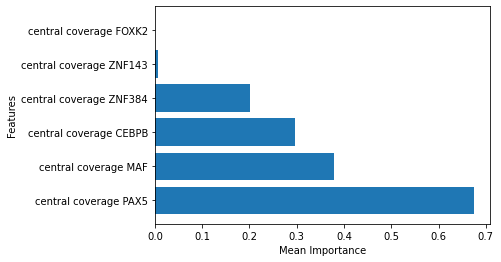

In [891]:
#fig = plt.gcf()
#fig.set_size_inches(9, 6)

d = LR_central_fi.mean(axis=1).sort_values(ascending=False).head(6)
d = d.rename(index={'central_coverage_PAX5': 'central coverage PAX5'})
d = d.rename(index={'central_coverage_MAF': 'central coverage MAF'})
d = d.rename(index={'central_coverage_CEBPB': 'central coverage CEBPB'})
d = d.rename(index={'central_coverage_ZNF384': 'central coverage ZNF384'})
d = d.rename(index={'central_coverage_ZNF143': 'central coverage ZNF143'})
d = d.rename(index={'central_coverage_FOXK2': 'central coverage FOXK2'})
print(d)

#plt.title('Logistic Regression with leave-one-out cross-validation')
plt.barh(d.index,d)
plt.xlabel('Mean Importance')
plt.ylabel('Features')

outfile = "thesis_plots/LogisticRegression_LOO_centralCoverage.pdf"
plt.savefig(outfile,bbox_inches='tight')

In [584]:
LR_central_bootstrap, LR_central_fi = LR_bootstrap(scaled_data_central,False,1000,False,feature_central)

print('Accuracy: %.3f' % LR_central_bootstrap['accuracy'].mean())
print('AUROC: %.3f' % LR_central_bootstrap['auc'].mean())

Accuracy: 0.783
AUROC: 0.876


In [586]:
RF_central_bootstrap, RF_central_fi = RF_bootstrap(scaled_data_central,False,1000,False,feature_central)

print('Accuracy: %.3f' % RF_central_bootstrap['accuracy'].mean())
print('AUROC: %.3f' % RF_central_bootstrap['auc'].mean())

Accuracy: 0.772
AUROC: 0.873


In [629]:
#RF_central_fi.mean(axis=1).sort_values(ascending=False).head(10)

central_coverage_PAX5       0.030805
central_coverage_MAF        0.028145
central_coverage_CEBPB      0.018103
central_coverage_ZNF384     0.017786
central_coverage_FLI1       0.017372
central_coverage_FOXK2      0.013842
central_coverage_ZNF22      0.011813
central_coverage_YY1        0.009764
central_coverage_RUNX1      0.009693
central_coverage_ZNF444     0.009607
central_coverage_ZNF143     0.008798
central_coverage_PROX1      0.008666
central_coverage_NEUROG2    0.008441
central_coverage_CEBPA      0.008410
central_coverage_OTX2       0.008258
central_coverage_VEZF1      0.007779
central_coverage_ZBTB6      0.007029
central_coverage_CREM       0.006771
central_coverage_IRF4       0.006618
central_coverage_ERF        0.006451
dtype: float64

### Mean cov:

In [72]:
LR_mean_loo, LR_mean_fi = LR_loo(scaled_data_mean,False,False,feature_mean)

LR_mean_loo

fpr         [0.0, 0.0, 0.0, 0.018518518518518517, 0.018518...
tpr         [0.0, 0.018518518518518517, 0.0370370370370370...
accuracy                                             0.555556
auc                                                  0.515775
dtype: object

In [74]:
#LR_mean_fi.mean(axis=1).sort_values(ascending=False).head(10)

In [589]:
LR_mean_bootstrap, LR_mean_fi = LR_bootstrap(scaled_data_mean,False,1000,False,feature_mean)

print('Accuracy: %.3f' % LR_mean_bootstrap['accuracy'].mean())
print('AUROC: %.3f' % LR_mean_bootstrap['auc'].mean())

Accuracy: 0.489
AUROC: 0.483


In [591]:
RF_mean_bootstrap, RF_mean_fi = RF_bootstrap(scaled_data_mean,False,1000,False,feature_mean)

print('Accuracy: %.3f' % RF_mean_bootstrap['accuracy'].mean())
print('AUROC: %.3f' % RF_mean_bootstrap['auc'].mean())

Accuracy: 0.518
AUROC: 0.579


In [631]:
#RF_mean_fi.mean(axis=1).sort_values(ascending=False).head(10)

mean_coverage_GFI1B     0.008176
mean_coverage_ZFHX2     0.007833
mean_coverage_HIF3A     0.007795
mean_coverage_NFATC1    0.006991
mean_coverage_ZNF770    0.006836
mean_coverage_IKZF1     0.006601
mean_coverage_PAX7      0.006523
mean_coverage_GLIS1     0.006463
mean_coverage_BATF      0.006076
mean_coverage_FOXO1     0.006000
mean_coverage_ELK4      0.005932
mean_coverage_PROX1     0.005932
mean_coverage_GABPA     0.005741
mean_coverage_ZNF264    0.005559
mean_coverage_POU5F1    0.005549
mean_coverage_SP1       0.005538
mean_coverage_HOXA2     0.005406
mean_coverage_CEBPG     0.005312
mean_coverage_ZNF24     0.005310
mean_coverage_ZNF143    0.005271
dtype: float64

# different scores

In [594]:
### WPS
cancer_type = "breast_cancer"
GC = "corrected"
score = "WPS"
amplitude = "FFT"

# cancer features
file = "/data/gpfs-1/groups/ag_kircher/cfDNA-analysis/lea/cfDNA_classification_analyses/features/DELFI_"+cancer_type+"_"+GC+"_"+score+"_"+amplitude+"_features.csv"
c_features = pd.read_csv(file, sep="\t", index_col=0)

file = "/data/gpfs-1/groups/ag_kircher/cfDNA-analysis/lea/cfDNA_classification_analyses/features/DELFI_breast_cancer_metadata.tsv"
c_meta = pd.read_csv(file, sep='\t', index_col='sample_name')

c_features = c_features.reset_index(drop=False)
c_features[['sample','p','score']] = c_features['index'].str.split('_',2, expand=True)
c_features = c_features.set_index('sample')
cancer = pd.concat([c_features, c_meta], axis=1)

# healthy features
file = "/data/gpfs-1/groups/ag_kircher/cfDNA-analysis/lea/cfDNA_classification_analyses/features/DELFI_healthy_"+GC+"_"+score+"_"+amplitude+"_features.csv"
h_features = pd.read_csv(file, sep="\t", index_col=0)

file = "/data/gpfs-1/groups/ag_kircher/cfDNA-analysis/lea/cfDNA_classification_analyses/features/DELFI_healthy_metadata.tsv"
h_meta = pd.read_csv(file, sep='\t', index_col='sample_name')

h_features = h_features.reset_index(drop=False)
h_features[['sample','p','score']] = h_features['index'].str.split('_',2, expand=True)
h_features = h_features.set_index('sample')
healthy = pd.concat([h_features, h_meta], axis=1)

data_wps = pd.concat([cancer, healthy], axis=0) #pd.concat([data1, data2], axis=0)
features_wps = data_wps.columns[(data_wps.columns.str.startswith('central_cov')) | (data_wps.columns.str.startswith('mean_cov')) | (data_wps.columns.str.startswith('amplitude')) | (data_wps.columns.str.startswith('nucleosome_spacing'))]

scaled_data_wps = pd.concat([cancer, healthy], axis=0) 
scaler = StandardScaler()
scaler.fit(scaled_data_wps[features_wps])
scaled_data_wps[features_wps] = scaler.transform(scaled_data_wps[features_wps])
scaled_data_wps[features_wps].mean()

central_coverage_MSC           -4.746782e-15
mean_coverage_MSC              -7.087365e-12
amplitude190_MSC                2.298059e-15
nucleosome_spacing_fft_MSC      0.000000e+00
central_coverage_REL           -1.724444e-15
                                    ...     
nucleosome_spacing_fft_ZEB1     5.612794e-16
central_coverage_HOMEZ         -3.568133e-15
mean_coverage_HOMEZ             5.246386e-12
amplitude190_HOMEZ             -1.983399e-15
nucleosome_spacing_fft_HOMEZ    0.000000e+00
Length: 1508, dtype: float64

In [595]:
### COV
cancer_type = "breast_cancer"
GC = "corrected"
score = "COV"
amplitude = "FFT"

# cancer features
file = "/data/gpfs-1/groups/ag_kircher/cfDNA-analysis/lea/cfDNA_classification_analyses/features/DELFI_"+cancer_type+"_"+GC+"_"+score+"_"+amplitude+"_features.csv"
c_features = pd.read_csv(file, sep="\t", index_col=0)

file = "/data/gpfs-1/groups/ag_kircher/cfDNA-analysis/lea/cfDNA_classification_analyses/features/DELFI_breast_cancer_metadata.tsv"
c_meta = pd.read_csv(file, sep='\t', index_col='sample_name')

c_features = c_features.reset_index(drop=False)
c_features[['sample','p','score']] = c_features['index'].str.split('_',2, expand=True)
c_features = c_features.set_index('sample')
cancer = pd.concat([c_features, c_meta], axis=1)

# healthy features
file = "/data/gpfs-1/groups/ag_kircher/cfDNA-analysis/lea/cfDNA_classification_analyses/features/DELFI_"+healthy_type+"_"+GC+"_"+score+"_"+amplitude+"_features.csv"
h_features = pd.read_csv(file, sep="\t", index_col=0)

file = "/data/gpfs-1/groups/ag_kircher/cfDNA-analysis/lea/cfDNA_classification_analyses/features/DELFI_healthy_metadata.tsv"
h_meta = pd.read_csv(file, sep='\t', index_col='sample_name')

h_features = h_features.reset_index(drop=False)
h_features[['sample','p','score']] = h_features['index'].str.split('_',2, expand=True)
h_features = h_features.set_index('sample')
healthy = pd.concat([h_features, h_meta], axis=1)

data_cov = pd.concat([cancer, healthy], axis=0) #pd.concat([data1, data2], axis=0)
features_cov = data_cov.columns[(data_cov.columns.str.startswith('central_cov')) | (data_cov.columns.str.startswith('mean_cov')) | (data_cov.columns.str.startswith('amplitude')) | (data_cov.columns.str.startswith('nucleosome_spacing'))]

scaled_data_cov = pd.concat([cancer, healthy], axis=0) 
scaler = StandardScaler()
scaler.fit(scaled_data_cov[features_cov])
scaled_data_cov[features_cov] = scaler.transform(scaled_data_cov[features_cov])
scaled_data_cov[features_cov].mean()

central_coverage_NFYC          -1.066534e-16
mean_coverage_NFYC             -7.420258e-13
amplitude190_NFYC              -1.500857e-16
nucleosome_spacing_fft_NFYC    -4.893205e-16
central_coverage_ATF7          -7.435924e-15
                                    ...     
nucleosome_spacing_fft_SIX5     1.387779e-17
central_coverage_NR5A2          2.611080e-15
mean_coverage_NR5A2             2.471317e-12
amplitude190_NR5A2              1.531697e-16
nucleosome_spacing_fft_NR5A2   -6.887495e-16
Length: 1508, dtype: float64

### WPS:

In [831]:
LR_wps_loo, LR_wps_fi = LR_loo(scaled_data_wps,False,False,features_wps)

LR_wps_loo

fpr         [0.0, 0.0, 0.0, 0.018518518518518517, 0.018518...
tpr         [0.0, 0.018518518518518517, 0.2962962962962963...
accuracy                                             0.694444
auc                                                  0.831276
dtype: object

In [833]:
#LR_wps_fi.mean(axis=1).sort_values(ascending=False).head(10)

central_coverage_ESRRA         0.355230
central_coverage_ATF2          0.127333
central_coverage_ZNF24         0.121022
mean_coverage_SP4              0.091760
mean_coverage_KLF15            0.077880
nucleosome_spacing_fft_HES1    0.032411
central_coverage_PLAG1         0.026949
central_coverage_ETV2          0.024642
central_coverage_NR5A2         0.019514
central_coverage_TP63          0.017265
nucleosome_spacing_fft_CDX2    0.004791
central_coverage_NEUROG2       0.002639
central_coverage_GATA4         0.002144
central_coverage_PPARD         0.001032
mean_coverage_GFI1             0.000793
central_coverage_HAND2         0.000560
nucleosome_spacing_fft_GFI1    0.000307
central_coverage_ZNF768        0.000201
mean_coverage_NEUROG2          0.000156
central_coverage_MIXL1         0.000000
dtype: float64

In [596]:
LR_wps_bootstrap, LR_wps_fi = LR_bootstrap(scaled_data_wps,False,1000,False,features_wps)

print('Accuracy: %.3f' % LR_wps_bootstrap['accuracy'].mean())
print('AUROC: %.3f' % LR_wps_bootstrap['auc'].mean())

Accuracy: 0.719
AUROC: 0.801


In [599]:
RF_wps_bootstrap, RF_wps_fi = RF_bootstrap(scaled_data_wps,False,1000,False,features_wps)

print('Accuracy: %.3f' % RF_wps_bootstrap['accuracy'].mean())
print('AUROC: %.3f' % RF_wps_bootstrap['auc'].mean())

Accuracy: 0.750
AUROC: 0.852


In [634]:
#RF_wps_fi.mean(axis=1).sort_values(ascending=False).head(10)

central_coverage_ESRRA      0.010498
central_coverage_ZNF24      0.008559
central_coverage_ATF2       0.008051
central_coverage_ZNF768     0.007903
central_coverage_USF1       0.007578
central_coverage_ZNF770     0.007418
central_coverage_NKX2-5     0.007098
central_coverage_ZNF554     0.006966
central_coverage_PLAG1      0.006309
central_coverage_ESR2       0.005842
central_coverage_HNF4A      0.005633
central_coverage_ZKSCAN1    0.005588
central_coverage_MEIS2      0.005109
central_coverage_IKZF5      0.005100
amplitude190_MAX            0.004974
central_coverage_ZNF263     0.004922
central_coverage_ZNF121     0.004818
central_coverage_THRB       0.004679
central_coverage_USF2       0.004584
central_coverage_FOSB       0.004512
dtype: float64

### COV:

In [834]:
LR_cov_loo, LR_cov_fi = LR_loo(scaled_data_cov,False,False,features_cov)

LR_cov_loo

fpr         [0.0, 0.0, 0.0, 0.018518518518518517, 0.018518...
tpr         [0.0, 0.018518518518518517, 0.6111111111111112...
accuracy                                             0.777778
auc                                                  0.882716
dtype: object

In [836]:
#LR_cov_fi.mean(axis=1).sort_values(ascending=False).head(10)

central_coverage_ZNF768     0.700223
central_coverage_TP63       0.236669
mean_coverage_HEY1          0.158591
mean_coverage_REL           0.152764
central_coverage_NEUROG2    0.101397
central_coverage_ZBTB6      0.090951
mean_coverage_ZNF324        0.080672
amplitude190_PKNOX1         0.067926
central_coverage_GATA2      0.058660
mean_coverage_ZSCAN22       0.045105
mean_coverage_ZNF217        0.042868
central_coverage_MYOD1      0.009398
mean_coverage_MNT           0.006980
mean_coverage_XBP1          0.005186
mean_coverage_GMEB2         0.002633
mean_coverage_ZIM3          0.002288
mean_coverage_OVOL2         0.000994
central_coverage_HNF4A      0.000940
central_coverage_TBX5       0.000858
amplitude190_ZNF444         0.000143
dtype: float64

In [704]:
LR_cov_bootstrap, LR_cov_fi = LR_bootstrap(scaled_data_cov,False,1000,False,features_cov)

print('Accuracy: %.3f' % LR_cov_bootstrap['accuracy'].mean())
print('AUROC: %.3f' % LR_cov_bootstrap['auc'].mean())

Accuracy: 0.756
AUROC: 0.845


In [707]:
RF_cov_bootstrap, RF_cov_fi = RF_bootstrap(scaled_data_cov,False,1000,False,features_cov)

print('Accuracy: %.3f' % RF_cov_bootstrap['accuracy'].mean())
print('AUROC: %.3f' % RF_cov_bootstrap['auc'].mean())

Accuracy: 0.769
AUROC: 0.852


In [709]:
#RF_cov_fi.mean(axis=1).sort_values(ascending=False).head(10)

central_coverage_ZNF768     0.013622
central_coverage_HNF4A      0.012125
central_coverage_TP63       0.008313
central_coverage_MYOD1      0.007268
central_coverage_NEUROG2    0.006898
central_coverage_IRF4       0.006732
central_coverage_THRB       0.006731
central_coverage_MECOM      0.006641
central_coverage_ZBTB6      0.006482
central_coverage_GATA2      0.006008
central_coverage_ZNF554     0.005914
central_coverage_MLX        0.005601
central_coverage_ESRRA      0.005537
central_coverage_ESR2       0.005222
central_coverage_TCF4       0.005155
central_coverage_KLF6       0.005149
central_coverage_MEIS1      0.005134
central_coverage_TBX5       0.005029
central_coverage_NFIL3      0.004994
central_coverage_ZNF3       0.004558
dtype: float64

# Plots

<Figure size 648x432 with 0 Axes>

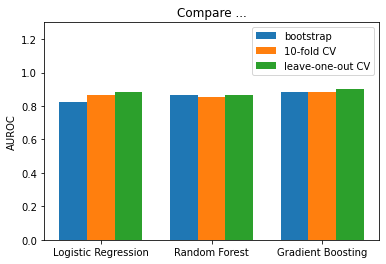

In [841]:
fig = plt.gcf()
fig.set_size_inches(9, 6)

methods = ("Logistic Regression", "Random Forest", "Gradient Boosting")
models = {
    'bootstrap': (lr_bootstrap_perf['auc'].mean(), rf_bootstrap_perf['auc'].mean(), gbc_bootstrap_perf['auc'].mean()),
    '10-fold CV': (lr_10fold_perf['auc'].mean(), rf_10fold_perf['auc'].mean(), gbc_10fold_perf['auc'].mean()),
    'leave-one-out CV': (lr_loo_AUC, rf_loo_AUC, gbc_loo_AUC),
}

x = np.arange(len(methods))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots()

for attribute, measurement in models.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    #ax.errorbar(x + offset, measurement, yerr=0.2, color="k", fmt="o")
    #ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('AUROC')
ax.set_title('Compare ...')
#ax.set_xticks(x + width, methods)
plt.xticks(x+width, ['Logistic Regression', 'Random Forest', 'Gradient Boosting'])
ax.legend(loc='upper right')
ax.set_ylim(0, 1.3)
#ax.set_ylim(0, 250)

plt.show()

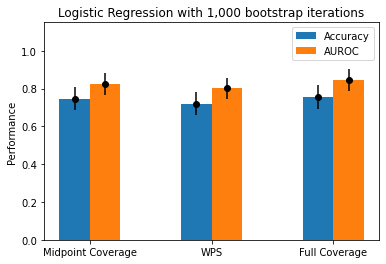

In [842]:
#fig = plt.gcf()
#fig.set_size_inches(9, 6)

methods = ("Midpoint Coverage", "WPS", "Full Coverage")
models = {
    'Accuracy': (lr_bootstrap_perf['accuracy'].mean(), LR_wps_bootstrap['accuracy'].mean(), LR_cov_bootstrap['accuracy'].mean()),
    'AUROC': (lr_bootstrap_perf['auc'].mean(), LR_wps_bootstrap['auc'].mean(), LR_cov_bootstrap['auc'].mean()),
}
errors = {
    'Accuracy': (lr_bootstrap_perf['accuracy'].std(), LR_wps_bootstrap['accuracy'].std(), LR_cov_bootstrap['accuracy'].std()),
    'AUROC': (lr_bootstrap_perf['auc'].std(), LR_wps_bootstrap['auc'].std(), LR_cov_bootstrap['auc'].std()),
}

x = np.arange(len(methods))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0.5

fig, ax = plt.subplots()

#print(models.items())
#print(errors.items())

for attribute, measurement in models.items():
    #print("measurement", measurement)
    #print("error", errors[attribute])
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.errorbar(x + offset, measurement, yerr=errors[attribute], color="k", fmt="o")
    #ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Performance')
ax.set_title('Logistic Regression with 1,000 bootstrap iterations')
#ax.set_xticks(x + width, methods)
plt.xticks(x+width, ["Midpoint Coverage", "WPS", "Full Coverage"])
ax.legend(loc='upper right')
ax.set_ylim(0, 1.15)
#ax.set_ylim(0, 250)

outfile = "thesis_plots/LogisticRegression_bootstrap_compareScores.pdf"
plt.savefig(outfile,bbox_inches='tight')

In [84]:
extension="png"

NameError: name 'rf_loo_perf' is not defined

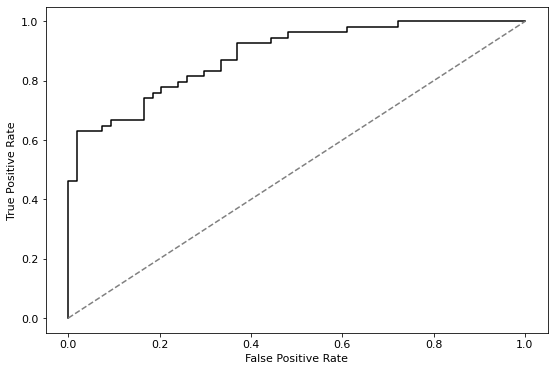

In [85]:
### COMPARE MODELS

fig = plt.gcf()
fig.set_size_inches(9, 6)


#plt.title('Receiver Operating Characteristic')
plt.plot(lr_loo_perf['fpr'], lr_loo_perf['tpr'], 'k', label = 'Logistic Regression (%0.2f)' % lr_loo_perf['auc'])
plt.plot([0, 1], [0, 1], "gray", linestyle='--')
#plt.xlim([0, 1])
#plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')  

plt.plot(rf_loo_perf['fpr'], rf_loo_perf['tpr'], 'c', label = 'Random Forest (%0.2f)' % rf_loo_perf['auc'])

plt.plot(gbc_loo_perf['fpr'], gbc_loo_perf['tpr'], 'g', label = 'Gradient Boosting Classifier (%0.2f)' % gbc_loo_perf['auc'])

plt.legend(loc = 'lower right')
#plt.show()

outfile = "thesis_plots/LOO_compare_binary_classification."+extension
plt.savefig(outfile)

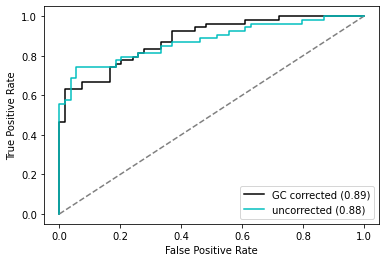

In [872]:
### CORRECTION

# RF
#fig = plt.gcf()
#fig.set_size_inches(9, 6)

#plt.title('Receiver Operating Characteristic')
plt.plot(lr_loo_perf['fpr'], lr_loo_perf['tpr'], 'k', label = 'GC corrected (%0.2f)' % lr_loo_perf['auc'])
plt.plot([0, 1], [0, 1], "gray", linestyle='--')
#plt.xlim([0, 1])
#plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
    
plt.plot(LR_uncorrected_loo['fpr'], LR_uncorrected_loo['tpr'], 'c', label = 'uncorrected (%0.2f)' % LR_uncorrected_loo['auc'])

plt.legend(loc = 'lower right')
#plt.show()

outfile = "thesis_plots/LR_LOO_correction."+extension
plt.savefig(outfile)

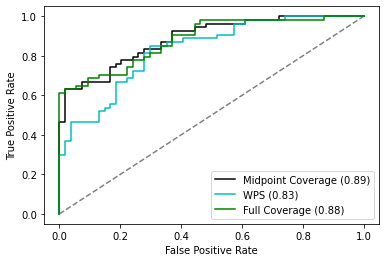

In [873]:
### DIFFERENT SCORES

#fig = plt.gcf()
#fig.set_size_inches(9, 6)

#plt.title('ROC Curve of Logistic Regression with leave-one-out CV')
plt.plot(lr_loo_perf['fpr'], lr_loo_perf['tpr'], 'k', label = 'Midpoint Coverage (%0.2f)' % lr_loo_perf['auc'])
plt.plot([0, 1], [0, 1], "gray", linestyle='--')
#plt.xlim([0, 1])
#plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.plot(LR_wps_loo['fpr'], LR_wps_loo['tpr'], 'c', label = 'WPS (%0.2f)' % LR_wps_loo['auc'])

plt.plot(LR_cov_loo['fpr'], LR_cov_loo['tpr'], 'g', label = 'Full Coverage (%0.2f)' % LR_cov_loo['auc'])

plt.legend(loc = 'lower right')
#plt.show()

outfile = "thesis_plots/LR_LOO_compare_scores."+extension
plt.savefig(outfile)

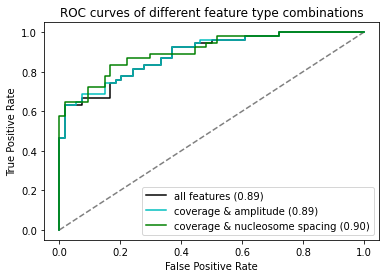

In [887]:
### 3 FEATURES

# RF
#fig = plt.gcf()
#fig.set_size_inches(9, 6)

plt.title('ROC curves of different feature type combinations')
plt.plot(lr_loo_perf['fpr'], lr_loo_perf['tpr'], 'k', label = 'all features (%0.2f)' % lr_loo_perf['auc'])
plt.plot([0, 1], [0, 1], "gray", linestyle='--')
#plt.xlim([0, 1])
#plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.plot(LR_griffin_loo['fpr'], LR_griffin_loo['tpr'], 'c', label = 'coverage & amplitude (%0.2f)' % LR_griffin_loo['auc'])

plt.plot(LR_mix_loo['fpr'], LR_mix_loo['tpr'], 'g', label = 'coverage & nucleosome spacing (%0.2f)' % LR_mix_loo['auc'])

plt.legend(loc = 'lower right')
#plt.show()

outfile = "thesis_plots/LR_LOO_compare_3features."+extension
plt.savefig(outfile)

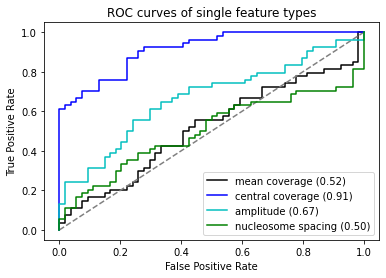

In [888]:
### SINGLE FEATURES

# RF
#fig = plt.gcf()
#fig.set_size_inches(9, 6)


plt.title('ROC curves of single feature types')
plt.plot(LR_mean_loo['fpr'], LR_mean_loo['tpr'], 'k', label = 'mean coverage (%0.2f)' % LR_mean_loo['auc'])
plt.plot([0, 1], [0, 1], "gray", linestyle='--')
#plt.xlim([0, 1])
#plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.plot(LR_central_loo['fpr'], LR_central_loo['tpr'], 'b', label = 'central coverage (%0.2f)' % LR_central_loo['auc'])

plt.plot(LR_amplitude_loo['fpr'], LR_amplitude_loo['tpr'], 'c', label = 'amplitude (%0.2f)' % LR_amplitude_loo['auc'])

plt.plot(LR_mine_loo['fpr'], LR_mine_loo['tpr'], 'g', label = 'nucleosome spacing (%0.2f)' % LR_mine_loo['auc'])

plt.legend(loc = 'lower right')
#plt.show()

outfile = "thesis_plots/LR_LOO_compare_single_features."+extension
plt.savefig(outfile)